### Импорты

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix

%matplotlib inline

### Загружаем данные

Массивы X содержат grayscale изображения цифр, массивы Y - метки, т.е. значения цифр.

In [2]:
from keras.datasets import mnist
(X_raw, y_raw), (X_test_raw, y_test_raw) = mnist.load_data()

Размер каждого изображения 28x28, в массиве для обучения 60000 элементов

In [3]:
X_raw.shape

(60000, 28, 28)

In [4]:
X_test_raw.shape

(10000, 28, 28)

Отображаем 6-й элемент для обучения

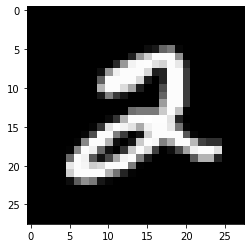

In [5]:
plt.figure(figsize=(4, 4))
_ = plt.imshow(X_raw[5], cmap='gray')

Значение метки (цифра) для 6-го элемента 

In [6]:
y_raw[5]

2

### Готовим данные

Посмотрим, что у нас с данными.

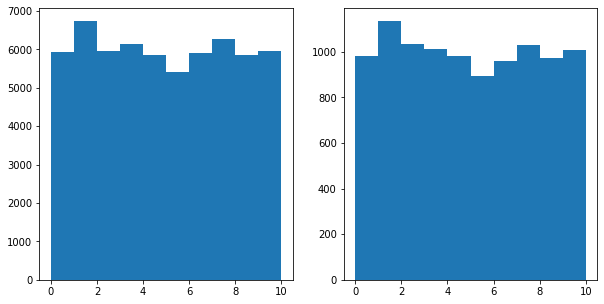

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
_ = ax1.hist(y_raw, range(0, 11))
_ = ax2.hist(y_test_raw, range(0, 11))

In [8]:
print(X_raw.max(), X_raw.min(), X_raw.mean())
print(X_test_raw.max(), X_test_raw.min(), X_test_raw.mean())

255 0 33.318421449829934
255 0 33.791224489795916


Распределение по классам примерно равномерное. Каждая картинка кодируется 28x28 пикселями со значениями от 0 до 255. Работать с матрицей пиксилей неудобно, так что линеаризируем изображение и заодно приведём значения пиксилей к диапазону от 0 до 1.

In [9]:
pixels = 28
X_train = X_raw.reshape(-1, pixels*pixels) / 255
X_train.shape

(60000, 784)

In [10]:
y_train = y_raw
y_train.shape

(60000,)

Анализируя датасет, можно заметить что на некоторых изображениях цифры нарисованы под углами и неплохо было бы "выровнять" их перед обучением модели. Иными словами, к изображениям применено некоторое аффинное преобразование, и в качестве предобработки необходимо применить к изображениям обратное аффинное преобразование.

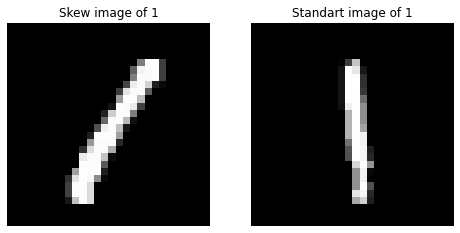

In [11]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_axis_off()
ax1.set_title(f"Skew image of {y_train[3]}")
_ = ax1.imshow(X_train[3].reshape(pixels, pixels), cmap='gray')
ax2.set_axis_off()
ax2.set_title(f"Standart image of {y_train[8]}")
_ = ax2.imshow(X_train[8].reshape(pixels, pixels), cmap='gray')

In [12]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]]
    totalImage = np.sum(image)
    m0 = np.sum(c0*image)/totalImage
    m1 = np.sum(c1*image)/totalImage
    m00 = np.sum((c0-m0)**2*image)/totalImage
    m11 = np.sum((c1-m1)**2*image)/totalImage
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage
    mu_vector = np.array([m0,m1])
    covariance_matrix = np.array([[m00,m01],[m01,m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    image = image.reshape(28, 28)
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [13]:
X_train = np.apply_along_axis(deskew, -1, X_train).reshape(-1, pixels*pixels)
X_train = (X_train - X_train.min()) / (X_train.max() -  X_train.min())

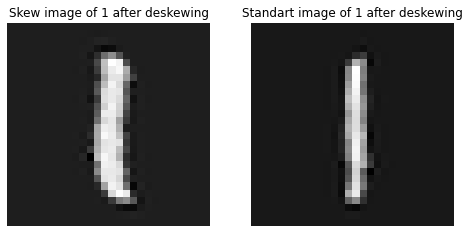

In [14]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_axis_off()
ax1.set_title(f"Skew image of {y_train[3]} after deskewing")
_ = ax1.imshow(X_train[3].reshape(pixels, pixels), cmap='gray')
ax2.set_axis_off()
ax2.set_title(f"Standart image of {y_train[8]} after deskewing")
_ = ax2.imshow(X_train[8].reshape(pixels, pixels), cmap='gray')

Сократим размерность пространства признаков. На то есть несколько причин:
 - Уменьшение размерности может привести к улучшению качества модели. И вот почему: сейчас мы имеем 784 признака, попиксельно кодирующие изображения. В этом случае пространство признаков это пространство всех векторов из 784х компонент. При этом, взяв случайный вектор из этого пространства с большой вероятностью мы получим просто шум, не являющийся цифрой. Таким образом, все цифры лежат в каком то пространстве меньшей размерности. Соответсвенно сократив размерность, используя более информативные признаки, мы можем качественно улучшить модель.
 - Уменьшение размерности сократит время обучения модели и занимаемую память.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8, whiten=True, random_state=2021)
X_train = pca.fit_transform(X_train)
X_train.shape

(60000, 33)

### Выбираем модель

Для оценки качества модели будем использовать метрику точности (`accuracy`). Сравнение будем производить при помощи валидации по 5 фолдам. 

In [16]:
seed = 2021
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [17]:
def validate(cls, X, y, kf, verbose=False):
    scores = np.zeros(kf.get_n_splits())
    for i, (idxs_train, idxs_val) in enumerate(kf.split(X)):
        if verbose:
            print("On Fold", i + 1)

        X_train = X[idxs_train]
        X_val = X[idxs_val]
        y_train = y[idxs_train]
        y_val = y[idxs_val]

        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_val)
        scores[i] = accuracy_score(y_val, y_pred)

        if verbose:
            print("With score", scores[i])
        del X_train, X_val, y_train, y_val
    return scores

В качестве базовой модели используем метод опорных векторов с линейным ядром (`LinearSVC`).

In [18]:
cls = LinearSVC(C=1.0, dual=False)

linear_scores = validate(cls, X_train, y_train, kf)

print(linear_scores)
print("Mean score", linear_scores.mean())

[0.93133333 0.93275    0.93308333 0.93425    0.93516667]
Mean score 0.9333166666666667


Линейная модель даёт неплохой результат. Однако, кажется что данные не совсем линейно разделимы. Улучшим модель при помощи kernel trick. В качестве ядра выберем `RBF`.

Для такого большого датасета достаточно накладно явно считать расстояния (с помощью `rbf_kernel` например). Вместо этого воспользуемся приближенными значениями посчитанными по части датасета.

In [19]:
from sklearn.kernel_approximation import Nystroem

gamma = 1 / (X_train.shape[1] * X_train.var())

# n_components определяет размер части датасета, по которой производятся вычисления
rbf_approximate = Nystroem(gamma=gamma, random_state=seed, n_components=1000) 
X_rbf_train = rbf_approximate.fit_transform(X_train)

cls = LinearSVC(C=1.0, dual=False)

rbf_approximate_scores = validate(cls, X_rbf_train, y_train, kf)

print(rbf_approximate_scores)
print("Mean score", rbf_approximate_scores.mean())

[0.98258333 0.98116667 0.98241667 0.98241667 0.98075   ]
Mean score 0.9818666666666666


Видно, что качество модели существенно возросло. Однако, из-за использования приближенной модели мы неизбежно теряем часть качества, и, хотя мы можем увеличивать значение `n_components` для улучшения точности, это приводит к увеличению затрат по памяти. Пойдем другим путем и воспользуемся моделью метода опорных векторов `SVC(kernel='rbf')`, где вычисления производятся по всему датасету и не требуют дополнительных расходов. При этом мы платим увеличением времени работы, что является разумной ценой (времени у нас точно больше, чем оперативной памяти).

In [20]:
cls = SVC(C=1.0, kernel='rbf', gamma='scale')

rbf_scores = validate(cls, X_train, y_train, kf)

print(rbf_scores)
print("Mean score", rbf_scores.mean())

[0.986      0.98783333 0.98658333 0.98575    0.98491667]
Mean score 0.9862166666666667


Теперь подберем константу C, используя валидацию.

In [22]:
C_grid = [0.01, 0.1, 0.5, 1, 3, 5, 10, 100]
C_scores = np.zeros(len(C_grid))

for ii, C in enumerate(C_grid):
    print("With param C = ", C)
    print("="*40)
    
    cls = SVC(C=C, kernel='rbf', gamma='scale')
    scores = validate(cls, X_train, y_train, kf, verbose=True)
    C_scores[ii] = scores.mean()

    print("Mean score", C_scores[ii])
    print("="*40)

print(f"Best C = {C_grid[C_scores.argmax()]} with score {C_scores.max()}")

With param C =  0.01
On Fold 1
With score 0.9498333333333333
On Fold 2
With score 0.9475
On Fold 3
With score 0.94825
On Fold 4
With score 0.94775
On Fold 5
With score 0.94775
Mean score 0.9482166666666666
With param C =  0.1
On Fold 1
With score 0.9764166666666667
On Fold 2
With score 0.975
On Fold 3
With score 0.9765833333333334
On Fold 4
With score 0.9755833333333334
On Fold 5
With score 0.9749166666666667
Mean score 0.9757
With param C =  0.5
On Fold 1
With score 0.9845
On Fold 2
With score 0.9843333333333333
On Fold 3
With score 0.985
On Fold 4
With score 0.9844166666666667
On Fold 5
With score 0.9835833333333334
Mean score 0.9843666666666667
With param C =  1
On Fold 1
With score 0.986
On Fold 2
With score 0.9878333333333333
On Fold 3
With score 0.9865833333333334
On Fold 4
With score 0.98575
On Fold 5
With score 0.9849166666666667
Mean score 0.9862166666666667
With param C =  3
On Fold 1
With score 0.98775
On Fold 2
With score 0.9888333333333333
On Fold 3
With score 0.9883333333

### Применяем лучшую модель на тестовой выборке

In [23]:
X_test = X_test_raw.reshape(-1, pixels*pixels) / 255
X_test = np.apply_along_axis(deskew, -1, X_test).reshape(-1, pixels*pixels)
X_test = (X_test - X_test.min()) / (X_test.max() -  X_test.min())
X_test = pca.transform(X_test)
X_test.shape

(10000, 33)

In [24]:
y_test = y_test_raw

In [25]:
cls = SVC(C=3, kernel='rbf', gamma='scale')
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

### Оцениваем результат

In [26]:
print("Accuracy на тестовой выборке", accuracy_score(y_test, y_pred))

Accuracy на тестовой выборке 0.9899


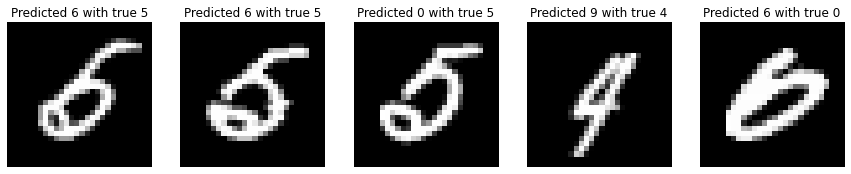

In [35]:
mistakes = np.where(y_pred != y_test)[0][-5:]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
for ax, image, pred, true  in zip(axes, X_test_raw[mistakes], y_pred[mistakes], y_test_raw[mistakes]):
    ax.set_axis_off()
    ax.set_title(f"Predicted {pred} with true {true}")
    image = image.reshape(pixels, pixels)
    ax.imshow(image, cmap='gray')

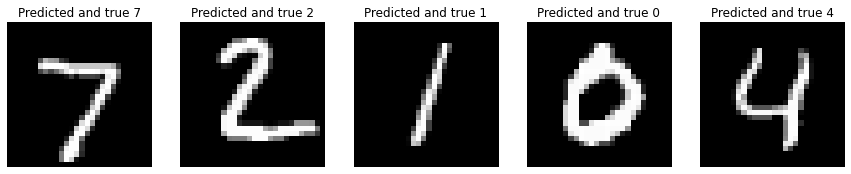

In [32]:
trues = np.where(y_pred == y_test)[0][:5]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
for ax, image, true  in zip(axes, X_test_raw[trues], y_test_raw[trues]):
    ax.set_axis_off()
    ax.set_title(f"Predicted and true {true}")
    image = image.reshape(pixels, pixels)
    ax.imshow(image, cmap='gray')

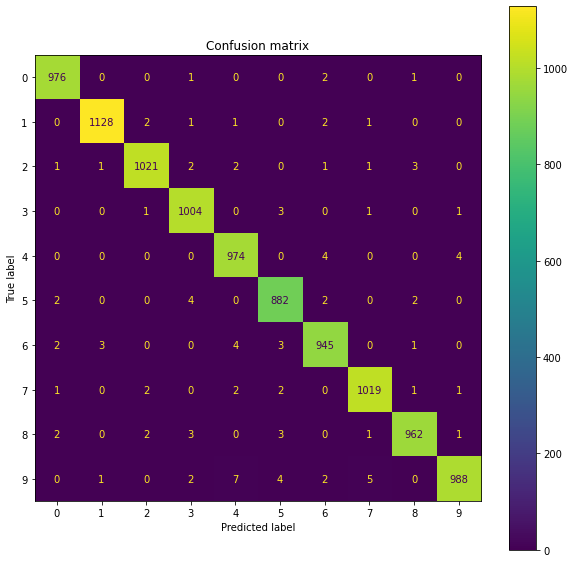

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_title("Confusion matrix")
_ = plot_confusion_matrix(cls, X_test, y_test, ax=ax)

### P.S. Немного магической визуализации

Магия требует времени, так что лучше просто посмотреть на картинку, а код не запускать.

In [33]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=100, perplexity=50, random_state=seed, n_iter=500)
X_magic = tsne.fit_transform(X_train[:10000])
y_magic = y_train[:10000]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.058s...
[t-SNE] Computed neighbors for 10000 samples in 5.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.356697
[t-SNE] Computed conditional probabilities in 0.436s
[t-SNE] Iteration 50: error = 91.1024246, gradient norm = 0.0000612 (50 iterations in 355.980s)
[t-SNE]

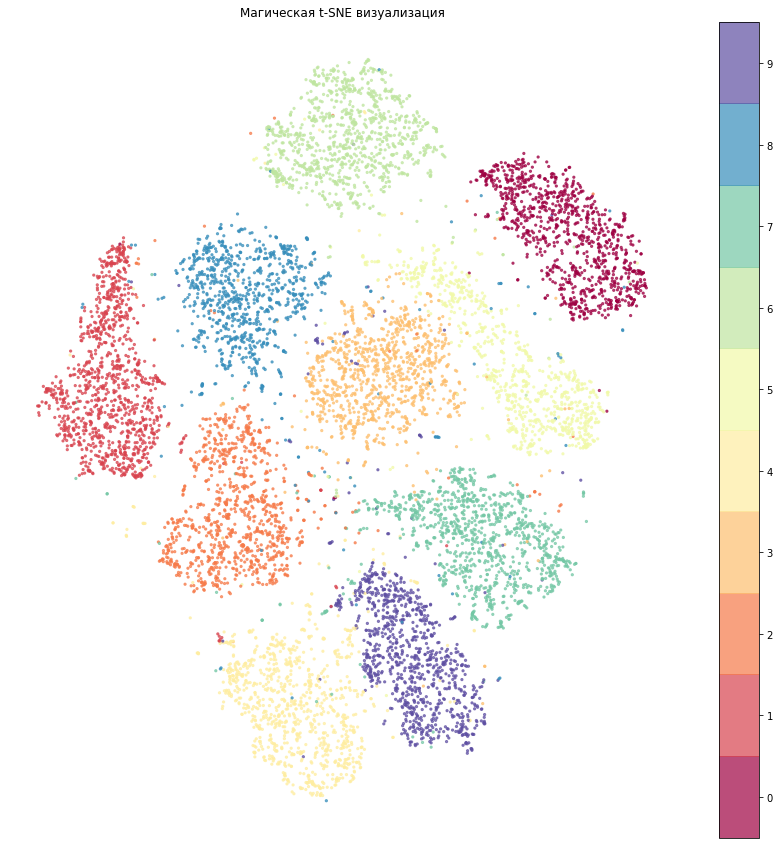

In [37]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_title("Магическая t-SNE визуализация")
ax.set_axis_off()
sc = ax.scatter(X_magic[:, 0], X_magic[:, 1], c=y_magic, cmap='Spectral', s=5, alpha=0.7)
_ = fig.colorbar(sc, boundaries=np.arange(11)-0.5, ticks=np.arange(10), ax=ax)